# Global Power Plant Database

In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# metrics and models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys
from sklearn import metrics
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score,r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/wri/global-power-plant-database/master/source_databases_csv/database_IND.csv')
data.head()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,generation_data_source,estimated_generation_gwh
0,IND,India,ACME Solar Tower,WRI1020239,2.5,28.1839,73.2407,Solar,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IND,India,ADITYA CEMENT WORKS,WRI1019881,98.0,24.7663,74.6090,Coal,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IND,India,AES Saurashtra Windfarms,WRI1026669,39.2,21.9038,69.3732,Wind,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IND,India,AGARTALA GT,IND0000001,135.0,23.8712,91.3602,Gas,NaN,NaN,...,2019.0,NaN,617.789264,843.747,886.004428,663.774500,626.239128,NaN,Central Electricity Authority,NaN
4,IND,India,AKALTARA TPP,IND0000002,1800.0,21.9603,82.4091,Coal,Oil,NaN,...,2019.0,NaN,3035.550000,5916.370,6243.000000,5385.579736,7279.000000,NaN,Central Electricity Authority,NaN


In [3]:
data.shape

(907, 27)

In [4]:
data.isna().sum().sum()

10445

### There are lots of null values

In [5]:
data.columns

Index(['country', 'country_long', 'name', 'gppd_idnr', 'capacity_mw',
       'latitude', 'longitude', 'primary_fuel', 'other_fuel1', 'other_fuel2',
       'other_fuel3', 'commissioning_year', 'owner', 'source', 'url',
       'geolocation_source', 'wepp_id', 'year_of_capacity_data',
       'generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015',
       'generation_gwh_2016', 'generation_gwh_2017', 'generation_gwh_2018',
       'generation_gwh_2019', 'generation_data_source',
       'estimated_generation_gwh'],
      dtype='object')

In [6]:
# dropping irrelevant columns since most of them are just null values

data = data.drop(columns = ['country','country_long','other_fuel2','other_fuel3','wepp_id',
                            'generation_gwh_2013','generation_gwh_2019','generation_data_source',
                            'estimated_generation_gwh','year_of_capacity_data'],axis = 1)

In [7]:
data.shape

(907, 17)

In [8]:
data.isna().sum()

name                     0
gppd_idnr                0
capacity_mw              0
latitude                46
longitude               46
primary_fuel             0
other_fuel1            709
commissioning_year     380
owner                  565
source                   0
url                      0
geolocation_source      19
generation_gwh_2014    509
generation_gwh_2015    485
generation_gwh_2016    473
generation_gwh_2017    467
generation_gwh_2018    459
dtype: int64

In [9]:
# filling NaN values

data['latitude'] = data['latitude'].fillna(data['latitude'].mode()[0])
data['longitude'] = data['longitude'].fillna(data['longitude'].mode()[0])
data['other_fuel1'] = data['other_fuel1'].fillna(data['other_fuel1'].mode()[0])
data['commissioning_year'] = data['commissioning_year'].fillna(data['commissioning_year'].mode()[0])
data['owner'] = data['owner'].fillna(data['owner'].mode()[0])
data['geolocation_source'] = data['geolocation_source'].fillna(data['geolocation_source'].mode()[0])
data['generation_gwh_2014'] = data['generation_gwh_2014'].fillna(data['generation_gwh_2014'].mean())
data['generation_gwh_2015'] = data['generation_gwh_2015'].fillna(data['generation_gwh_2015'].mean())
data['generation_gwh_2016'] = data['generation_gwh_2016'].fillna(data['generation_gwh_2016'].mean())
data['generation_gwh_2017'] = data['generation_gwh_2017'].fillna(data['generation_gwh_2017'].mean())
data['generation_gwh_2018'] = data['generation_gwh_2018'].fillna(data['generation_gwh_2018'].mode()[0])

In [10]:
data.isna().sum().sum()

0

In [11]:
# replacing zero values with mean

data['generation_gwh_2014'] = data['generation_gwh_2014'].replace(0,data['generation_gwh_2014'].mean())
data['generation_gwh_2015'] = data['generation_gwh_2015'].replace(0,data['generation_gwh_2015'].mean())
data['generation_gwh_2016'] = data['generation_gwh_2016'].replace(0,data['generation_gwh_2016'].mean())
data['generation_gwh_2017'] = data['generation_gwh_2017'].replace(0,data['generation_gwh_2017'].mean())
data['generation_gwh_2018'] = data['generation_gwh_2018'].replace(0,data['generation_gwh_2018'].mean())

In [12]:
data.shape

(907, 17)

### Visualization for Nominal data

In [13]:
data_nom = data[['name','primary_fuel','other_fuel1','owner','source','url','geolocation_source']]

The value counts for name is

ACME Solar Tower           1
RAICHUR                    1
PRYAGRAJ (BARA) TPP        1
PULICHINTALA               1
PUNE MILL                  1
                          ..
KADANA                     1
KADRA                      1
KAHALGAON                  1
KAIGA                      1
iEnergy Theni Wind Farm    1
Name: name, Length: 907, dtype: int64 



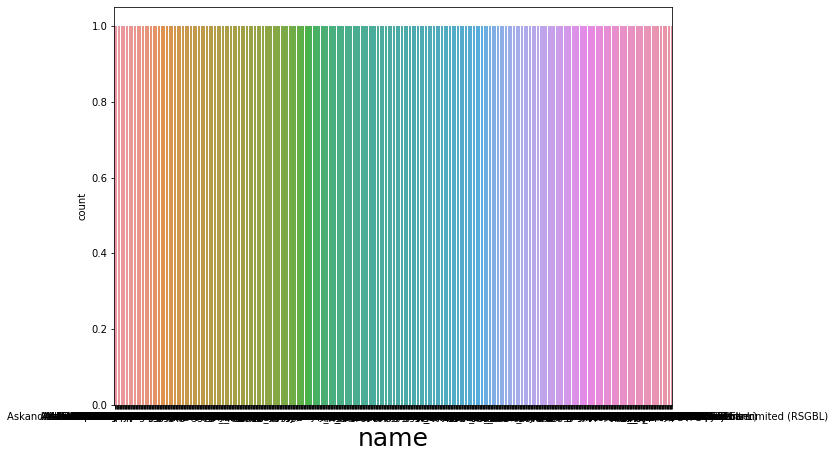

The value counts for primary_fuel is

Coal       258
Hydro      251
Solar      127
Wind       123
Gas         69
Biomass     50
Oil         20
Nuclear      9
Name: primary_fuel, dtype: int64 



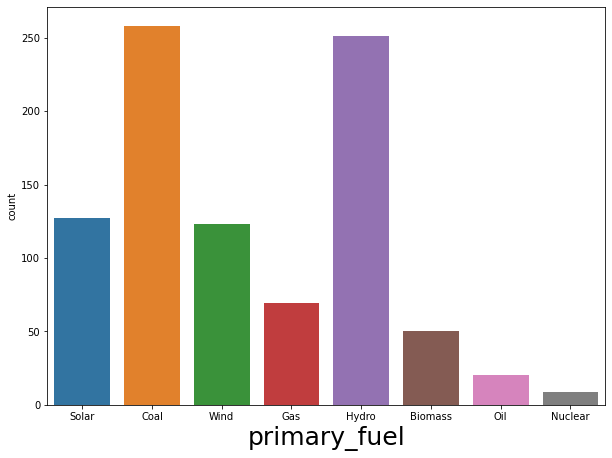

The value counts for other_fuel1 is

Oil             904
Gas               2
Cogeneration      1
Name: other_fuel1, dtype: int64 



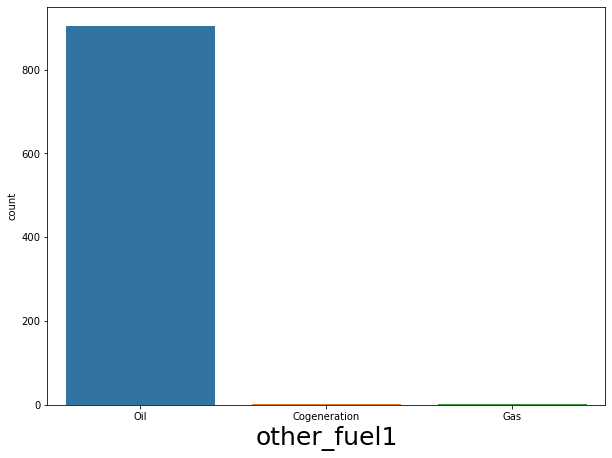

The value counts for owner is

Acc Acc ltd                                                    569
Sterling Agro Industries ltd.                                    4
Jk Cement ltd                                                    4
Maharashtra State Power Generation Co Ltd (MAHAGENCO)            3
Karnataka Power Corporation Limited                              3
                                                              ... 
Sunkon Energy Private Limited                                    1
West Bengal Energy Development Corporation Limited (WBEDCL)      1
Energy Infratech Private Limited                                 1
K. N. Ram                                                        1
iEnergy Wind Farms                                               1
Name: owner, Length: 280, dtype: int64 



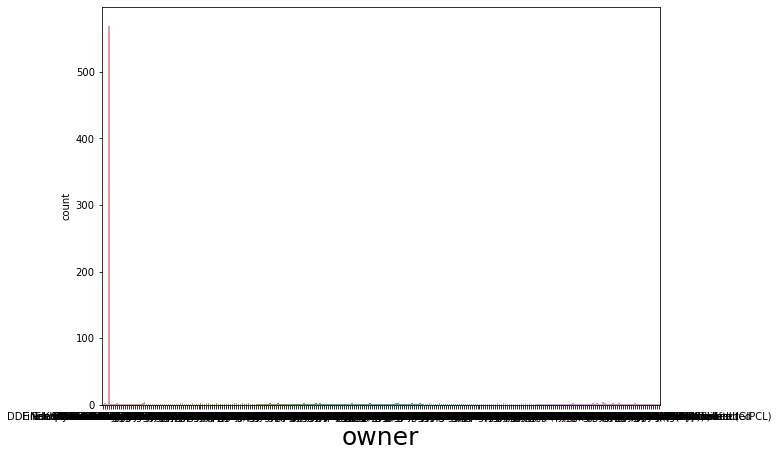

The value counts for source is

Central Electricity Authority                                  519
CDM                                                            124
Lancosola                                                       10
National Renewable Energy Laboratory                             8
National Thermal Power Corporation (NTPC)                        6
                                                              ... 
Harsha Engineers Limited                                         1
Godawari Energy ltd                                              1
Sunkon Energy Private Limited                                    1
West Bengal Energy Development Corporation Limited (WBEDCL)      1
Yashwantrao Krishna ssk                                          1
Name: source, Length: 191, dtype: int64 



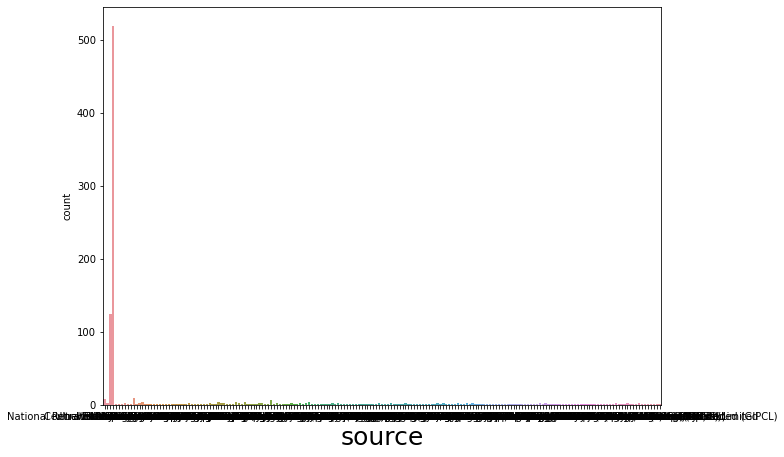

The value counts for url is

http://www.cea.nic.in/                                                              519
http://www.lancosolar.com/pdfs/rajasthan-pv-project-details.pdf                       7
http://www.ntpc.co.in                                                                 6
http://viainfotech.biz/Biomass/theme5/document/green_market/REC-project-list.pdf      5
http://www.mahaurja.com/PDF/PG2_GridConnSPPCommissioned.pdf                           4
                                                                                   ... 
https://cdm.unfccc.int/Projects/DB/LRQA%20Ltd1346322352.66/view                       1
https://cdm.unfccc.int/Projects/DB/DNV-CUK1351166669.28/view                          1
http://harshaengineers.com                                                            1
http://hiragroup.com/companies/godawari-green-energy-limited/                         1
https://cdm.unfccc.int/Projects/DB/RWTUV1345031355.85/view                            1
Nam

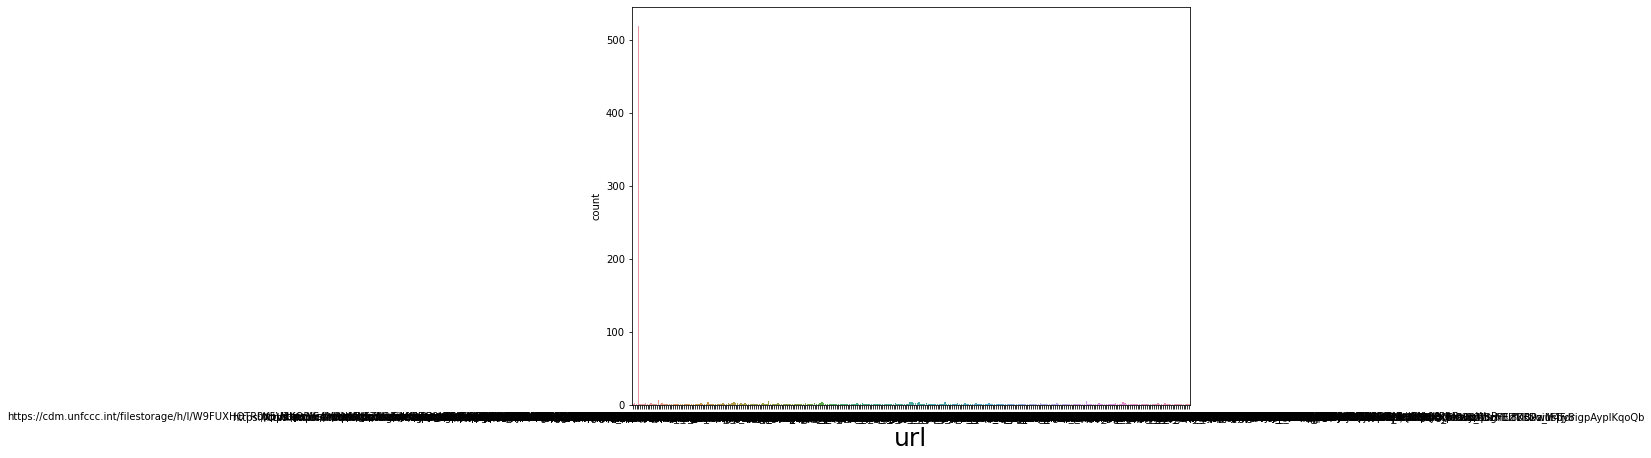

The value counts for geolocation_source is

WRI                                     784
Industry About                          119
National Renewable Energy Laboratory      4
Name: geolocation_source, dtype: int64 



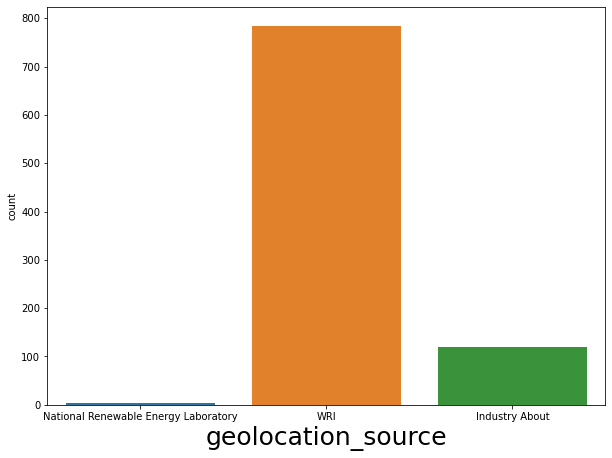

In [14]:
plotnumber = 1

for column in data_nom :
    plt.figure(figsize = (10,60))
    if plotnumber <= 7:
        ax = plt.subplot(7,1,plotnumber)
        sns.countplot(data_nom[column])
        plt.xlabel(column,fontsize = 25)
        print(f"The value counts for {column} is\n")
        print(data_nom[column].value_counts(),'\n')
        plt.show()
    plotnumber +=1

### Visualization for ordinal data

In [15]:
data_ord = data[['gppd_idnr','commissioning_year']]

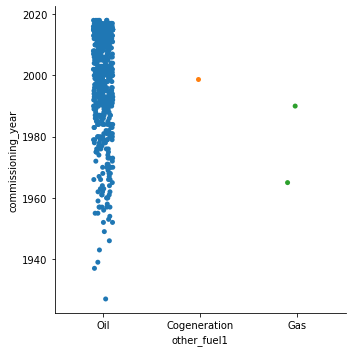

In [16]:
sns.catplot(x = 'other_fuel1',y = 'commissioning_year',data = data)

### Visualization for continuous data

In [17]:
data_cont = data[['capacity_mw','latitude','longitude','generation_gwh_2014','generation_gwh_2015','generation_gwh_2016',
                  'generation_gwh_2017','generation_gwh_2018']]

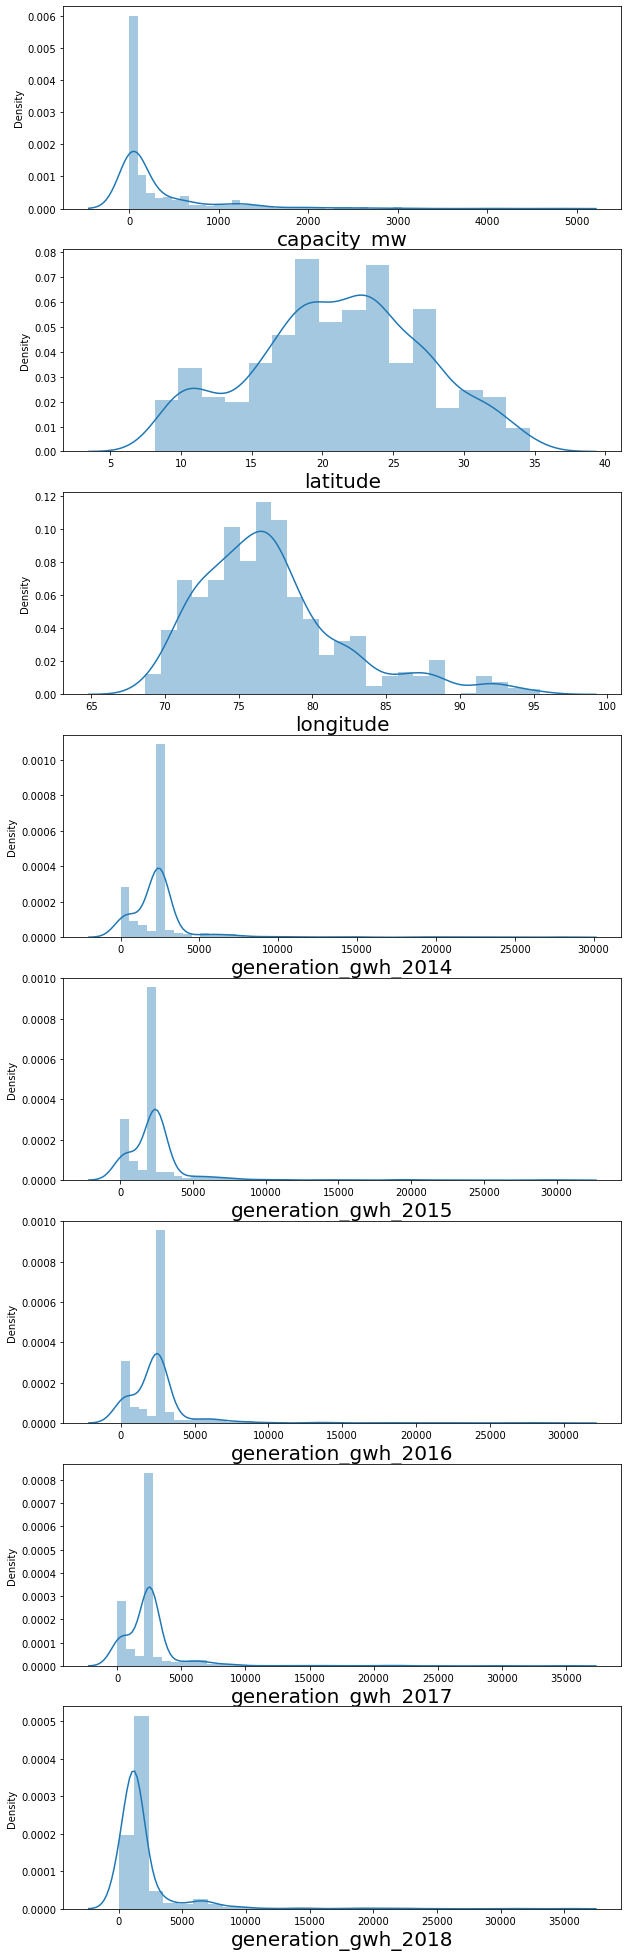

In [18]:
plt.figure(figsize = (10,35))
plotnumber = 1

for column in data_cont :
    if plotnumber <=8 :
        ax = plt.subplot(8,1,plotnumber)
        sns.distplot(data_cont[column])
        plt.xlabel(column,fontsize = 20)
    plotnumber +=1
plt.show()

## Encoding of dataframe

In [19]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [20]:
for i in data.columns:
    if data[i].dtypes == "object":
        data[i] = enc.fit_transform(data[i].values.reshape(-1,1))

In [21]:
data.head()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,source,url,geolocation_source,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
0,0.0,657.0,2.5,28.1839,73.2407,6.0,2.0,2011.0,229.0,109.0,128.0,1.0,2431.823590,2428.226946,2467.936859,2547.759305,1284.630911
1,1.0,519.0,98.0,24.7663,74.6090,1.0,2.0,2015.0,258.0,174.0,173.0,2.0,2431.823590,2428.226946,2467.936859,2547.759305,1284.630911
2,2.0,853.0,39.2,21.9038,69.3732,7.0,2.0,2015.0,2.0,21.0,205.0,2.0,2431.823590,2428.226946,2467.936859,2547.759305,1284.630911
3,3.0,0.0,135.0,23.8712,91.3602,2.0,2.0,2004.0,5.0,22.0,58.0,2.0,617.789264,843.747000,886.004428,663.774500,626.239128
4,4.0,1.0,1800.0,21.9603,82.4091,1.0,2.0,2015.0,5.0,22.0,58.0,2.0,3035.550000,5916.370000,6243.000000,5385.579736,7279.000000


In [22]:
data.describe()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,source,url,geolocation_source,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,453.000000,453.000000,326.223755,21.086467,77.172109,3.206174,1.995590,2004.594267,56.169791,43.847850,94.469680,1.733186,2506.896424,2500.511541,2549.566523,2637.647174,1989.974013
std,261.972645,261.972645,590.085456,6.098262,4.976401,2.280652,0.081259,15.734928,82.529116,44.642818,70.381222,0.677151,2629.757090,2827.530635,2841.461051,2880.593843,3077.872102
min,0.000000,0.000000,0.000000,8.168900,68.644700,0.000000,0.000000,1927.000000,0.000000,0.000000,0.000000,0.000000,0.045355,0.118300,0.099500,0.425769,0.056000
25%,226.500000,226.500000,16.725000,17.072000,73.811550,1.000000,2.000000,1998.000000,5.000000,22.000000,58.000000,2.000000,1687.488000,1370.462900,1365.502290,1472.802025,1284.630911
50%,453.000000,453.000000,59.200000,21.281800,76.493800,3.000000,2.000000,2014.000000,5.000000,22.000000,58.000000,2.000000,2431.823590,2428.226946,2467.936859,2547.759305,1284.630911
75%,679.500000,679.500000,385.250000,25.176450,79.206100,6.000000,2.000000,2015.000000,95.500000,29.500000,115.500000,2.000000,2431.823590,2428.226946,2467.936859,2547.759305,1284.630911
max,906.000000,906.000000,4760.000000,34.649000,95.408000,7.000000,2.000000,2018.000000,279.000000,190.000000,303.000000,2.000000,28127.000000,30539.000000,30015.000000,35116.000000,35136.000000


### Correlation check

In [23]:
data.corr()

,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,commissioning_year,owner,source,url,geolocation_source,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018
name,1.000000,0.332205,0.060240,-0.137256,0.011780,0.040753,-0.074663,-0.041465,0.098075,-0.014640,0.041917,0.036225,0.082742,0.077319,0.072573,0.077370,0.069899
gppd_idnr,0.332205,1.000000,-0.335742,-0.107710,-0.372802,0.609180,0.002333,0.511350,0.630589,0.416384,0.597080,-0.464174,0.021116,0.020202,0.007026,0.002518,-0.149234
capacity_mw,0.060240,-0.335742,1.000000,0.059041,0.215875,-0.380395,0.003105,-0.004072,-0.311048,-0.242122,-0.243830,0.204865,0.705576,0.716177,0.747254,0.769442,0.869080
latitude,-0.137256,-0.107710,0.059041,1.000000,0.055202,-0.020203,0.035587,0.035355,-0.069644,0.061738,-0.137512,-0.190907,0.040870,0.037620,0.029071,0.028328,0.047754
longitude,0.011780,-0.372802,0.215875,0.055202,1.000000,-0.368766,0.026114,-0.150742,-0.287117,-0.212166,-0.315160,0.220812,0.022136,0.026223,0.046257,0.051836,0.135406
primary_fuel,0.040753,0.609180,-0.380395,-0.020203,-0.368766,1.000000,0.004912,0.164947,0.284296,0.053613,0.589886,-0.483217,-0.137544,-0.133534,-0.139115,-0.146975,-0.243682
other_fuel1,-0.074663,0.002333,0.003105,0.035587,0.026114,0.004912,1.000000,0.056437,0.033687,0.026590,0.028154,-0.021408,0.013827,0.016816,0.009945,0.011099,0.013008
commissioning_year,-0.041465,0.511350,-0.004072,0.035355,-0.150742,0.164947,0.056437,1.000000,0.408917,0.322222,0.342155,-0.259929,0.115143,0.116744,0.136280,0.143473,0.056934
owner,0.098075,0.630589,-0.311048,-0.069644,-0.287117,0.284296,0.033687,0.408917,1.000000,0.769583,0.419773,-0.384838,-0.017720,-0.015868,-0.017832,-0.019369,-0.142244
source,-0.014640,0.416384,-0.242122,0.061738,-0.212166,0.053613,0.026590,0.322222,0.769583,1.000000,0.160144,-0.505720,-0.013986,-0.012525,-0.014075,-0.015288,-0.112276


<AxesSubplot:>

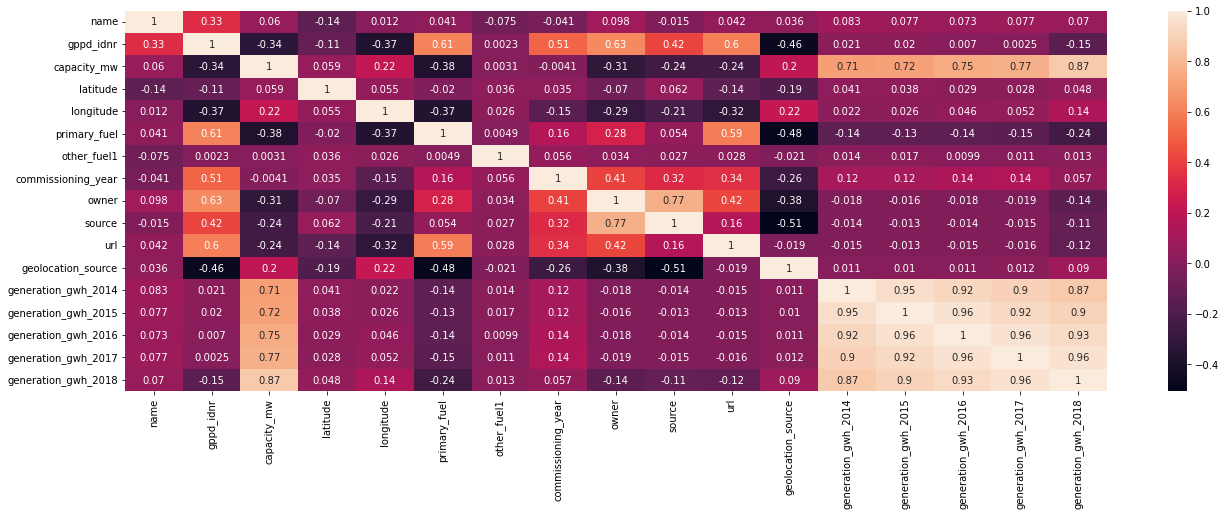

In [24]:
plt.figure(figsize = (22,7))
sns.heatmap(data.corr(), annot = True)

### Dealing with multicollinearity using VIF

In [25]:
x = data.drop(columns = ['capacity_mw'])
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [26]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]
vif['Features'] = x.columns

# Let's check the values
vif

,VIF,Features
0,1.528370,name
1,5.022860,gppd_idnr
2,1.120764,latitude
3,1.266446,longitude
4,3.929195,primary_fuel
5,1.014070,other_fuel1
6,1.706844,commissioning_year
7,3.799761,owner
8,4.017105,source
9,3.010360,url


In [27]:
data = data.drop(columns = ['generation_gwh_2014','generation_gwh_2015','generation_gwh_2016','generation_gwh_2017'])

### So, we have dealt with multicollinearity.

### Now, let's visualize the collinearity of features with the target

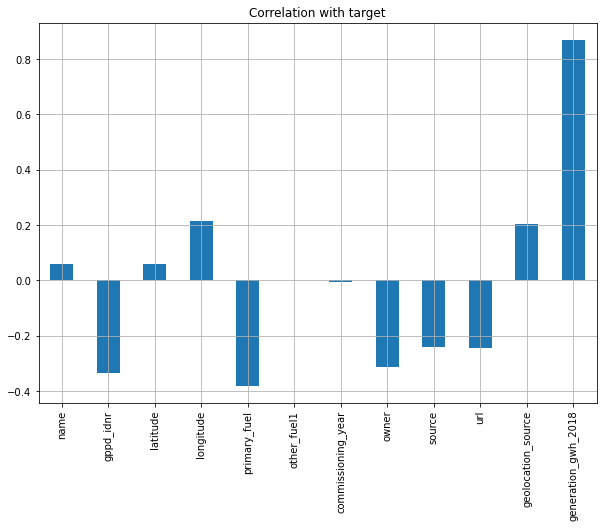

In [28]:
# finding correlation of features with target using corrwith
corr = data.drop('capacity_mw', axis = 1).corrwith(data.capacity_mw)
# Visualize the correlation
corr.plot(kind = 'bar', grid = True, figsize = (10,7),
          title = "Correlation with target")
plt.show()

In [29]:
# dropping columns having very less correlation with the target
data = data.drop(columns = ['other_fuel1','commissioning_year'],axis = 1)

### Dealing with skewness of the distribution of continuous data

In [30]:
data.skew()

name                   0.000000
gppd_idnr              0.000000
capacity_mw            3.123576
latitude              -0.095721
longitude              1.130252
primary_fuel           0.472251
owner                  1.364406
source                 1.827373
url                    1.510537
geolocation_source    -2.159841
generation_gwh_2018    5.302321
dtype: float64

**Columns which do not have skewness in the range +/-0.5 are :**
- capacity_mw (continuous data) - **target**
- longitude (continuous data) - **need to treat this**
- commissioning_year (ordinal data)
- owner (nominal data)
- source (nominal data)
- url (nominal data)
- geolocation_source (nominal data)
- generation_gwh_2018 (continuous data) - **need to treat this**

### Let's deal with skewness using power transform

In [31]:
dat_cont = ['longitude','generation_gwh_2018']
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'yeo-johnson')
data[dat_cont] = scaler.fit_transform(data[dat_cont].values)
data[dat_cont]

,longitude,generation_gwh_2018
0,-0.826778,0.032502
1,-0.431721,0.032502
2,-2.231266,0.032502
3,2.106598,-0.599058
4,1.144189,1.891307
...,...,...
902,0.238099,-0.522289
903,0.408358,0.032502
904,-0.177302,0.032502
905,-0.675056,0.032502


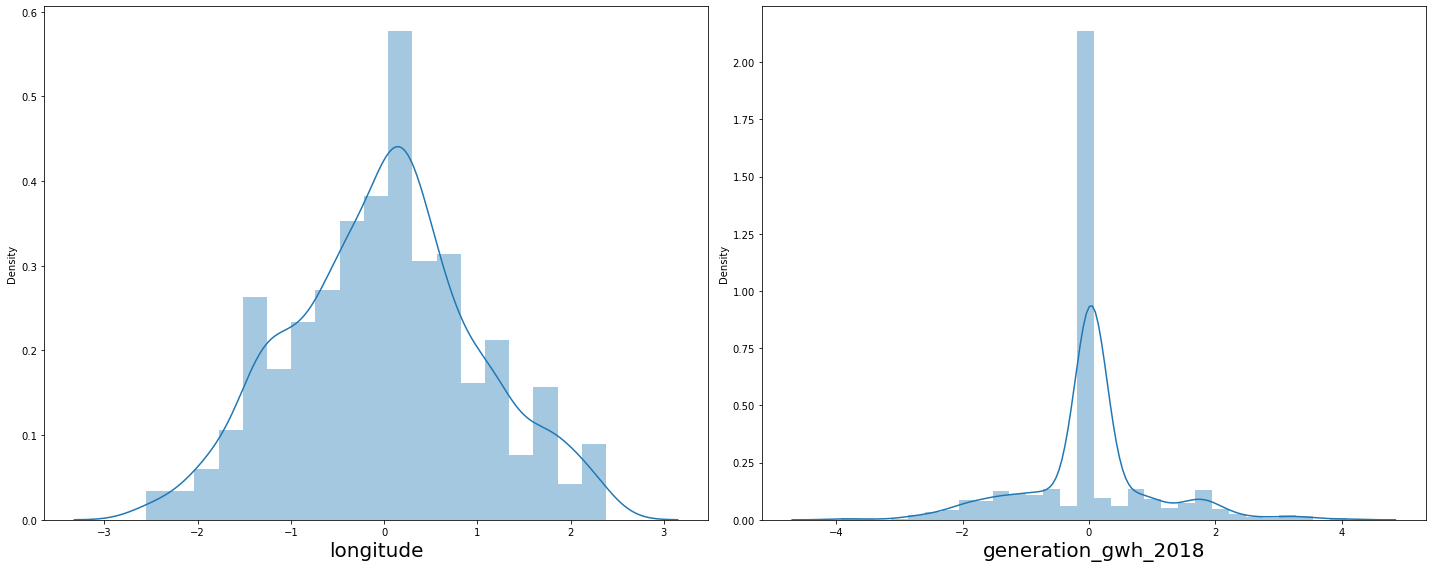

In [32]:
plt.figure(figsize = (20,8))
plotnumber = 1

for column in data[dat_cont]:
    if plotnumber<=2:
        ax = plt.subplot(1,2,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize = 20)
    plotnumber +=1
plt.tight_layout()

In [33]:
data.skew()

name                   0.000000
gppd_idnr              0.000000
capacity_mw            3.123576
latitude              -0.095721
longitude              0.040507
primary_fuel           0.472251
owner                  1.364406
source                 1.827373
url                    1.510537
geolocation_source    -2.159841
generation_gwh_2018    0.136618
dtype: float64

### Distribution looks more or less normal now since skewness has been removed.

### Separating columns into features and target
- We will not scale the data since most of the columns are categorical
- Since our target variable is continuous, it is a regression problem

## a) Making prediction for "Capacity_mw"

In [57]:
x = data.drop('capacity_mw',axis = 1)
y = data.capacity_mw

dt = DecisionTreeClassifier()
kn = KNeighborsClassifier()
bg = BaggingClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
lr = LinearRegression()
xgb = xgb.XGBRegressor()
svc = SVC()
svr = SVR()

In [58]:
for i in range(0,20):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25, random_state = i)
    lr.fit(x_train,y_train)
    y_train_pred = lr.predict(x_train)
    y_test_pred = lr.predict(x_test)
    print(f"At random state {i}, the training accuracy is : {r2_score(y_train,y_train_pred)}")
    print(f"At random state {i}, the testing accuracy is : {r2_score(y_test,y_test_pred)}\n")

At random state 0, the training accuracy is : 0.6027260311726585
At random state 0, the testing accuracy is : 0.6444592242020282

At random state 1, the training accuracy is : 0.6314344753185097
At random state 1, the testing accuracy is : 0.6012660649367059

At random state 2, the training accuracy is : 0.6304456480203627
At random state 2, the testing accuracy is : 0.589161801778622

At random state 3, the training accuracy is : 0.6197117187937065
At random state 3, the testing accuracy is : 0.6332472053483043

At random state 4, the training accuracy is : 0.6190746606512112
At random state 4, the testing accuracy is : 0.6271615228597323

At random state 5, the training accuracy is : 0.6197889351553916
At random state 5, the testing accuracy is : 0.6323406063670529

At random state 6, the training accuracy is : 0.6192499271705105
At random state 6, the testing accuracy is : 0.6319434602877305

At random state 7, the training accuracy is : 0.6373346281375425
At random state 7, the tes

In [59]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25, random_state = 10)

In [60]:
lr.fit(x_train, y_train)

LinearRegression()

In [61]:
y_test_pred = lr.predict(x_test)
print(f"The accuracy score is {r2_score(y_test,y_test_pred)*100:.2f} %")

The accuracy score is 62.28 %


### Cross Validation of the model

In [62]:
test_acc = r2_score(y_test,y_test_pred)

for i in range (2,10):
    cv_score = cross_val_score(lr,x,y,cv = i)
    cv_mean  = cv_score.mean()
    print(f"At cv = {i},cv_score = {cv_mean} and accuracy for testing = {test_acc}\n")

At cv = 2,cv_score = 0.5460151872556351 and accuracy for testing = 0.6228037947666407

At cv = 3,cv_score = 0.5666671416428469 and accuracy for testing = 0.6228037947666407

At cv = 4,cv_score = 0.5887121649425775 and accuracy for testing = 0.6228037947666407

At cv = 5,cv_score = 0.5936703807373178 and accuracy for testing = 0.6228037947666407

At cv = 6,cv_score = 0.5863965854815463 and accuracy for testing = 0.6228037947666407

At cv = 7,cv_score = 0.5932928394145441 and accuracy for testing = 0.6228037947666407

At cv = 8,cv_score = 0.5914643307090035 and accuracy for testing = 0.6228037947666407

At cv = 9,cv_score = 0.5774810734111594 and accuracy for testing = 0.6228037947666407



In [63]:
cv_score = cross_val_score(lr,x,y,cv = 5)
cv_mean = cv_score.mean()
cv_mean

0.5936703807373178

### Check for overfitting

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_train_pred = lr.predict(x_train)

print("\n---- Model Evaluation for TRAIN DATA ----\n")

print("MAE is : ",mean_absolute_error(y_train,y_train_pred))

print('MSE is :',mean_squared_error(y_train,y_train_pred))

print('RMSE is :',np.sqrt(mean_squared_error(y_train,y_train_pred)))

y_test_pred = lr.predict(x_test)

print("\n\n---- Model Evaluation for TEST DATA ----\n")

print("MAE is : ",mean_absolute_error(y_test,y_test_pred))

print('MSE is :',mean_squared_error(y_test,y_test_pred))

print('RMSE is :',np.sqrt(mean_squared_error(y_test,y_test_pred)))


---- Model Evaluation for TRAIN DATA ----

MAE is :  247.84102981067352
MSE is : 129335.1209997484
RMSE is : 359.63192433340566


---- Model Evaluation for TEST DATA ----

MAE is :  228.06878392766578
MSE is : 137227.4874759302
RMSE is : 370.44228629562554


**RMSE value did not vary much, we can say it is not overfitting**. Let's evaluate further - 

### L1 form

In [65]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
lasscv = LassoCV(alphas = None, max_iter = 2, normalize = True)
lasscv.fit(x_train,y_train)

LassoCV(max_iter=2, normalize=True)

In [66]:
alpha = lasscv.alpha_
alpha

0.04318451658089982

In [67]:
lasso_reg = Lasso(alpha)
lasso_reg.fit(x_train,y_train)

Lasso(alpha=0.04318451658089982)

In [68]:
lasso_reg.score(x_test,y_test)

0.6228045660046853

### L2 form

In [69]:
ridgecv = RidgeCV(alphas = np.arange(0.001,0.1,0.01),normalize = True) #arange = giving range for learning rate
ridgecv.fit(x_train,y_train)

RidgeCV(alphas=array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091]),
        normalize=True)

In [70]:
ridgecv.alpha_

0.011

In [71]:
ridge_model = Ridge(ridgecv.alpha_)
ridge_model.fit(x_train,y_train)

Ridge(alpha=0.011)

In [72]:
ridge_model.score(x_test,y_test)

0.6228034289902881

### L1 form and L2 form values are almost equal, so our model is not overfitting.
### Let's see a plot for our prediction

Text(0, 0.5, 'Predicted Capacity (in MW)')

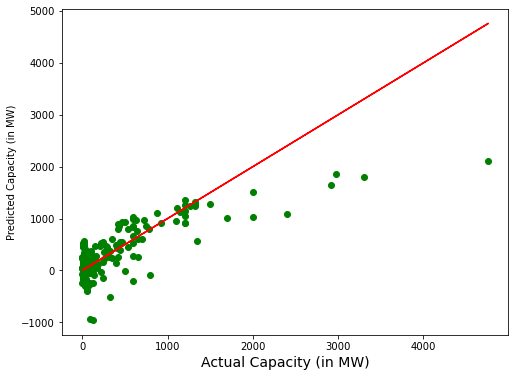

In [73]:
plt.figure(figsize = (8,6))
plt.scatter(x = y_test, y = y_test_pred, color = 'g')
plt.plot(y_test,y_test, color = 'r')
plt.xlabel('Actual Capacity (in MW)', fontsize = 14)
plt.ylabel('Predicted Capacity (in MW)')

**Best fit line is convering most of the data. So, our model looks good in fitting the data.**
### Regularization

In [74]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10],'random_state':list(range(0,10))}
ls = Lasso()
clf = GridSearchCV(ls,params)
clf.fit(x_train,y_train)

print(clf.best_params_)

{'alpha': 1, 'random_state': 0}


In [75]:
ls = Lasso(alpha = 1,random_state = 0)
ls.fit(x_train,y_train)
ls.score(x_train,y_train)
pred_ls = ls.predict(x_test)

lss = r2_score(y_test,pred_ls)
lss

0.6227856265217839

## b) Making prediction for Primary fuel

In [87]:
x = data.drop('primary_fuel',axis = 1)
y = data.primary_fuel

dt = DecisionTreeClassifier()
kn = KNeighborsClassifier()
bg = BaggingClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
xgb = xgb.XGBRegressor()
svc = SVC()
svr = SVR()

In [88]:
for i in range(0,20):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25, random_state = i)
    bg.fit(x_train,y_train)
    y_train_pred = bg.predict(x_train)
    y_test_pred = bg.predict(x_test)
    print(f"At random state {i}, the training accuracy is : {accuracy_score(y_train,y_train_pred)}")
    print(f"At random state {i}, the testing accuracy is : {accuracy_score(y_test,y_test_pred)}\n")

At random state 0, the training accuracy is : 0.9882352941176471
At random state 0, the testing accuracy is : 0.8678414096916299

At random state 1, the training accuracy is : 0.9852941176470589
At random state 1, the testing accuracy is : 0.8105726872246696

At random state 2, the training accuracy is : 0.9852941176470589
At random state 2, the testing accuracy is : 0.8149779735682819

At random state 3, the training accuracy is : 0.9941176470588236
At random state 3, the testing accuracy is : 0.8325991189427313

At random state 4, the training accuracy is : 0.9955882352941177
At random state 4, the testing accuracy is : 0.8370044052863436

At random state 5, the training accuracy is : 0.9852941176470589
At random state 5, the testing accuracy is : 0.8370044052863436

At random state 6, the training accuracy is : 0.9955882352941177
At random state 6, the testing accuracy is : 0.8105726872246696

At random state 7, the training accuracy is : 0.9897058823529412
At random state 7, the te

In [89]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25, random_state = 0)
bg.fit(x_train,y_train)

BaggingClassifier()

In [90]:
y_test_pred = bg.predict(x_test)
print(f"The accuracy score is {accuracy_score(y_test,y_test_pred)*100:.2f} %")

The accuracy score is 86.34 %


In [91]:
test_acc = accuracy_score(y_test,y_test_pred)

for i in range (2,10):
    cv_score = cross_val_score(bg,x,y,cv = i)
    cv_mean  = cv_score.mean()
    print(f"At cv = {i},cv_score = {cv_mean} and accuracy for testing = {test_acc}\n")

At cv = 2,cv_score = 0.7872139724402174 and accuracy for testing = 0.8634361233480177

At cv = 3,cv_score = 0.7784881137120334 and accuracy for testing = 0.8634361233480177

At cv = 4,cv_score = 0.8081751198783673 and accuracy for testing = 0.8634361233480177

At cv = 5,cv_score = 0.8280189423835832 and accuracy for testing = 0.8634361233480177

At cv = 6,cv_score = 0.8081793888695247 and accuracy for testing = 0.8634361233480177

At cv = 7,cv_score = 0.8135105204872647 and accuracy for testing = 0.8634361233480177

At cv = 8,cv_score = 0.837874553640739 and accuracy for testing = 0.8634361233480177

At cv = 9,cv_score = 0.8267766776677669 and accuracy for testing = 0.8634361233480177



In [92]:
cv_score = cross_val_score(bg,x,y,cv = 8)
cv_mean = cv_score.mean()
cv_mean

0.8257937432075765

In [109]:
import pickle
import joblib

joblib.dump(bg,'Global Power Plant Database.pkl')

['Global Power Plant Database.pkl']